In [73]:
import os
os.chdir('/Users/jacksonwalters/tensorflow_datasets')

In [74]:
import pandas as pd

filepath_dict = {'yelp':   'labeled_sentences/yelp_labelled.txt',
                 'amazon': 'labeled_sentences/amazon_cells_labelled.txt',
                 'imdb':   'labeled_sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [75]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

In [77]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)

In [78]:
vectorizer.fit(sentences)

CountVectorizer(lowercase=False, min_df=0)

In [79]:
#assign each word an index
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [80]:
#vectors representing word counts
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
#slice the df to get yelp sentences
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
sentences[14]

'I was disgusted because I was pretty sure that was human hair.'

In [83]:
#yelp sentence sentiment labels. 0 = negative, 1 = positive
y = df_yelp['label'].values; y[14]

0

In [84]:
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [85]:
#example of training data with label
(sentences_train[14],y_train[14])

('All of the tapas dishes were delicious!', 1)

In [86]:
#vectorize the training and test data by word counting
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer()

In [87]:
#vectorized training data
X_train = vectorizer.transform(sentences_train); X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [88]:
#vectorized test data
X_test  = vectorizer.transform(sentences_test); X_test

<250x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 2069 stored elements in Compressed Sparse Row format>

In [89]:
#perform a logistic regression on the training data and measure it against test data
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.796


In [90]:
#build a logistic regression model for each data source and test accuracy
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [91]:
#switching over to a non-linear model
#keras is a high level tool to build models/networks

In [92]:
from tensorflow import keras
from keras import Sequential
from keras import layers

In [93]:
input_dim = X_train.shape[1]  # Number of features

In [94]:
model = Sequential()

In [95]:
#add a layer w/ 10 nodes, relu activation
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))

In [96]:
#add a layer with 1 node, sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

In [97]:
model.compile(loss='binary_crossentropy', 
...               optimizer='adam', 
...               metrics=['accuracy'])

In [98]:
#summarize the model shape and parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                25060     
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit(X_train, y_train,
...                     epochs=100,
...                     verbose=False,
...                     validation_data=(X_test, y_test),
...                     batch_size=10)

/Users/jacksonwalters/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2022-01-11 15:44:24.008395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 15:44:25.944946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [100]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

In [101]:
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 1.0000


In [102]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)

In [103]:
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7807


In [104]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

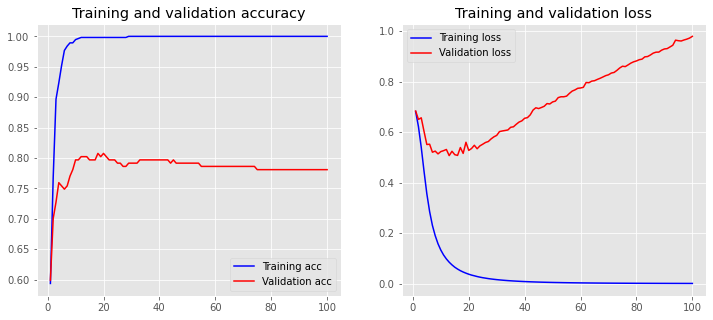

In [105]:
#plots over training epochs
#we want to stop training when our model starts performing worse on the validation
#data, so basically at the minimum of the red curve on the right.
plot_history(history)

In [137]:
#use one-hot encoding as an initial word embedding

In [107]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
encoder = LabelEncoder()

In [110]:
city_labels = encoder.fit_transform(cities)

In [111]:
city_labels

array([1, 0, 0, 2, 1])

In [112]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

In [113]:
city_labels = city_labels.reshape((5, 1))

In [114]:
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [115]:
from keras.preprocessing.text import Tokenizer

In [116]:
tokenizer = Tokenizer(num_words=5000)

In [117]:
#slice the df to get yelp sentences
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values

In [118]:
#yelp sentence sentiment labels. 0 = negative, 1 = positive
y = df_yelp['label'].values; y[14]

0

In [119]:
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [120]:
tokenizer.fit_on_texts(sentences_train)

In [121]:
X_train = tokenizer.texts_to_sequences(sentences_train)

In [122]:
X_test = tokenizer.texts_to_sequences(sentences_test)

In [123]:
vocab_size = len(tokenizer.word_index) + 1; vocab_size  # Adding 1 because of reserved 0 index

1747

In [124]:
print(sentences_train[2])

Of all the dishes, the salmon was the best, but all were great.


In [125]:
#vocab indices
print(X_train[2])

[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [126]:
#some words in the vocab
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
happy: 320
sad: 450


In [127]:
from keras.preprocessing.sequence import pad_sequences

In [128]:
maxlen = 100

In [129]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

In [130]:
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [131]:
print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [132]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           87350     
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                50010     
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


2022-01-11 15:47:16.660273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 15:47:18.815417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 15:47:41.879718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 1.0000
Testing Accuracy:  0.7400


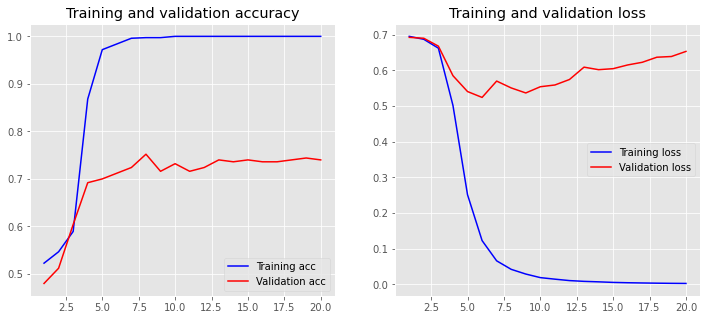

In [133]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [136]:
#use global maxpooling to reduce the dimension of the one-hot encoding

In [134]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


2022-01-11 15:47:42.522480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 15:47:44.741551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 15:48:44.750921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 1.0000
Testing Accuracy:  0.8240


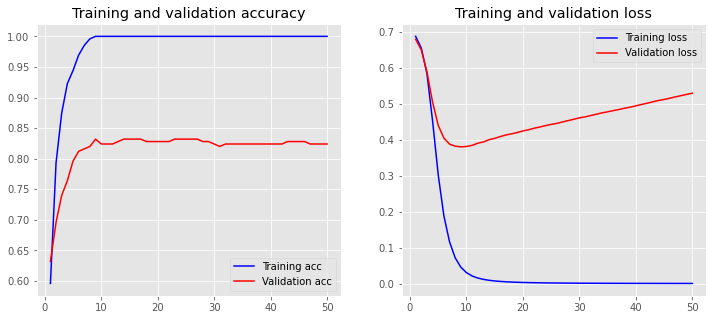

In [135]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [138]:
#using pretrained word embeddings such as gloVe, spaCy, or word2vec

In [147]:
#create an embedding matrix. index of word corresponds to wordvector.
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [142]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove/glove.6B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [143]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

In [144]:
nonzero_elements / vocab_size

0.9507727532913566

In [148]:
#build a model a layer with pretrained weights. that is,
#we're setting the weights of the first layer to just give 
#the wordvector
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 10)                510       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________


2022-01-11 16:18:12.806054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:18:13.456656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:18:32.063167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 0.7747
Testing Accuracy:  0.7240


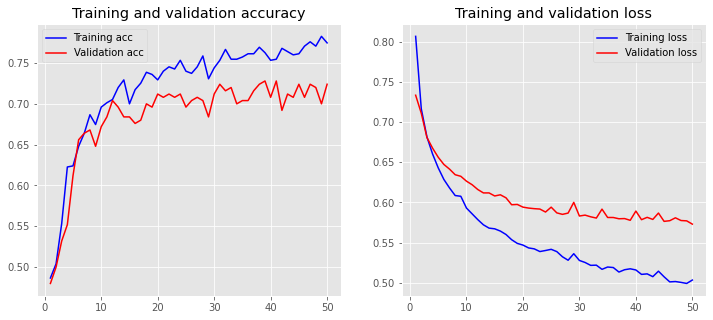

In [149]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [150]:
#set the pretrained weights initially, but allow them
#to be adjusted during training
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


2022-01-11 16:20:30.639715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:20:32.452761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:21:31.384410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 1.0000
Testing Accuracy:  0.7640


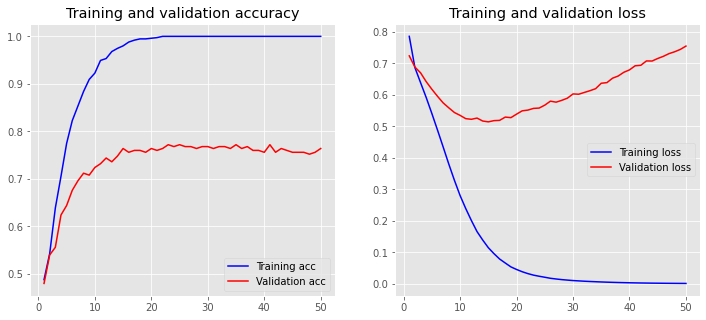

In [151]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [154]:
#use a 1d convolutional layer, i.e. a moving window over the sentence data

In [152]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          174700    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_______________________________________________

In [156]:
#the training set is a bit small to really improve performance

2022-01-11 16:22:51.536846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:22:54.351012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:23:06.264655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 1.0000
Testing Accuracy:  0.7960


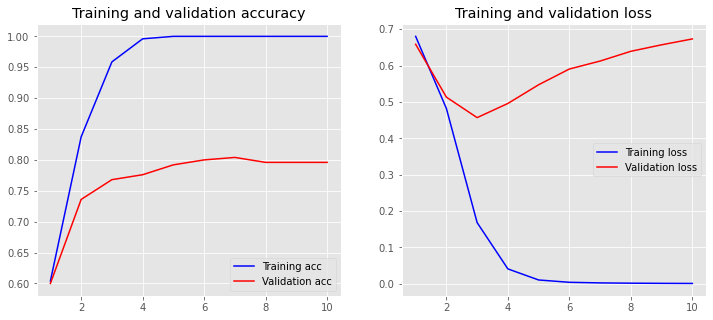

In [155]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [157]:
#there are a handful of parameters that went into creating the model
#we'd like to find the set of parameters with the best performance
#one "hyperparameter" is k if we partition the training data into k sets
#since we hold one k for validation, this gives k sets to use
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [158]:
#once the parameters are defined, we can form a grid to search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
#this will take awhile, as we are training the models over and over again
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/var/folders/4d/rp7dhwss6znf18sks0v304d80000gn/T/ipykernel_1441/3755212897.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model,
2022-01-11 16:29:33.732368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:30:28.451997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-11 16:30:29.038662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
